In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import astropy
from astropy.table import Table

In [2]:
# reference flux
s0=15
dat = Table.read('differential_sky_area.ecsv')
s= np.append(dat['detection_threshold'], 15)
fov_tot = np.append(dat['sky_area'], 1897*175)
counts = np.zeros_like(s)
counts[-1] = 1

# Bayes factor calculation for different models.

## Baseline M1 with uninformative priors and MSSS+OVRO data

Initializing SMC sampler...
Sampling 8 chains in 8 jobs
Stage:   0 Beta: 0.174
Stage:   1 Beta: 0.809
Stage:   2 Beta: 1.000


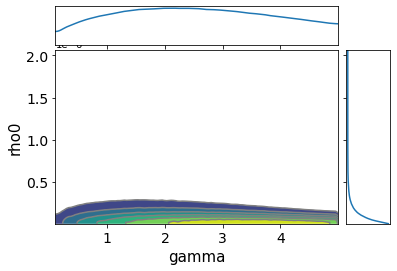

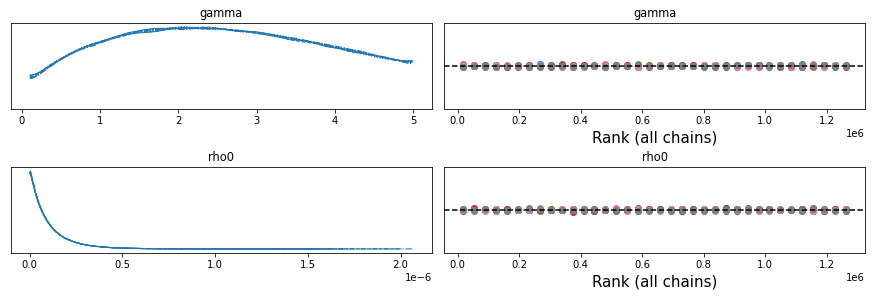

In [3]:
with pm.Model() as m1_both: 
    g = pm.Bound(pm.Kumaraswamy,lower=8e-6)('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-14, upper=-3, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    pm.Poisson("n", mu=rho0*((s/s0)**(-gamma))*fov_tot, observed=counts)
    trace = pm.sample_smc(draws=160000, parallel=True, cores=8)
    az.plot_pair(trace, marginals=True, kind='kde', var_names=['gamma', 'rho0'], kde_kwargs={'contour':True})
    az.plot_trace(trace, kind="rank_vlines",var_names=['gamma', 'rho0'])

In [4]:
with m1_both:
    print(np.mean(trace.report.log_marginal_likelihood), np.std((trace.report.log_marginal_likelihood)))

-6.701540337685918 0.0038080875782630615


# Uniform prior on r

Initializing SMC sampler...
Sampling 8 chains in 8 jobs
Stage:   0 Beta: 0.173
Stage:   1 Beta: 0.615
Stage:   2 Beta: 1.000


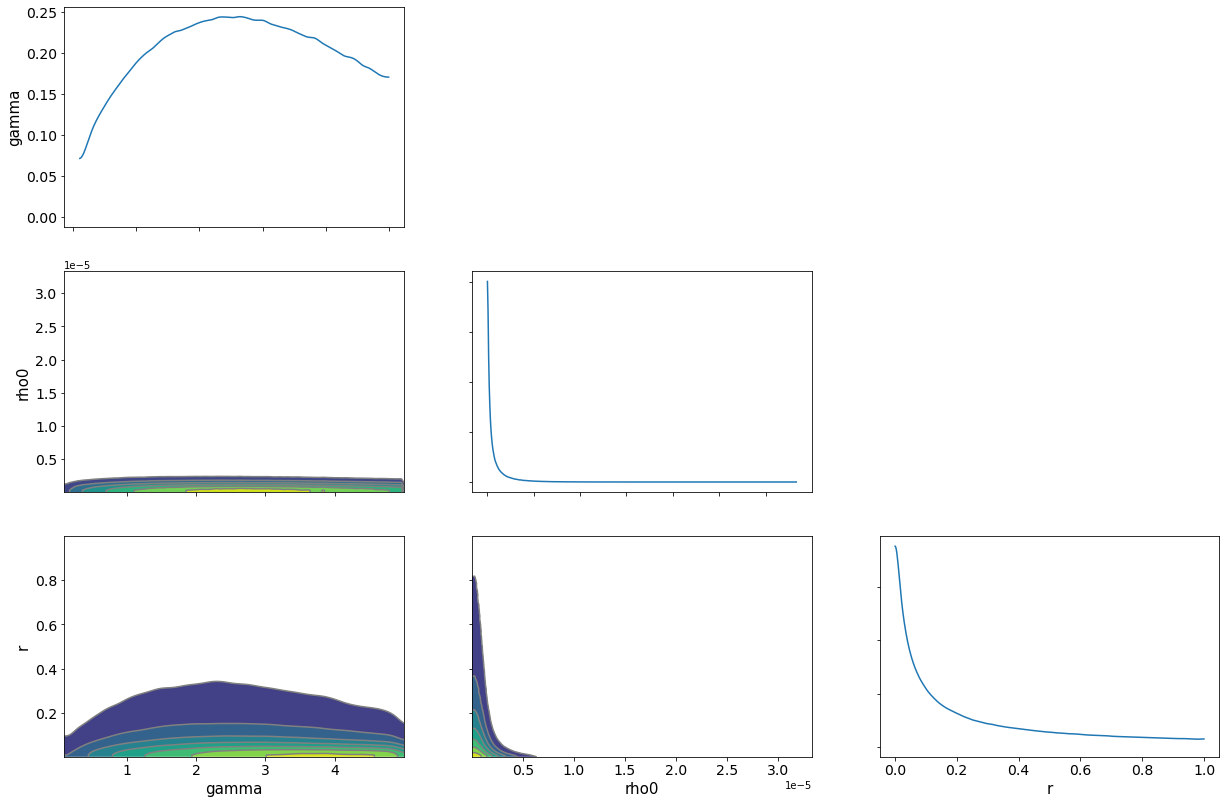

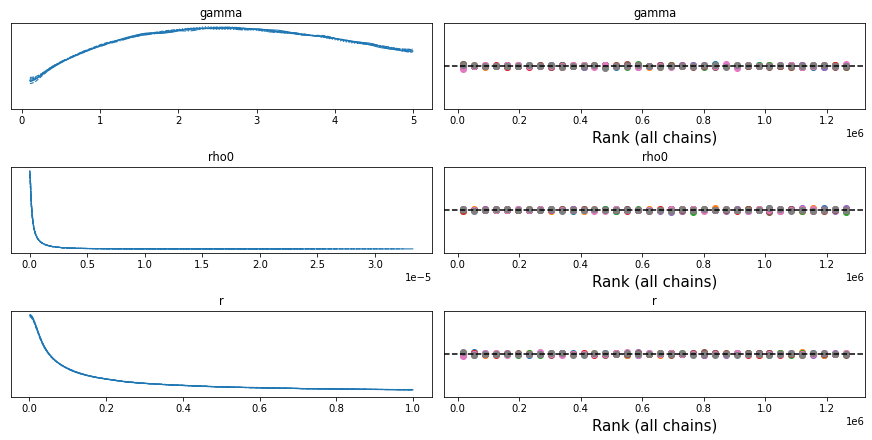

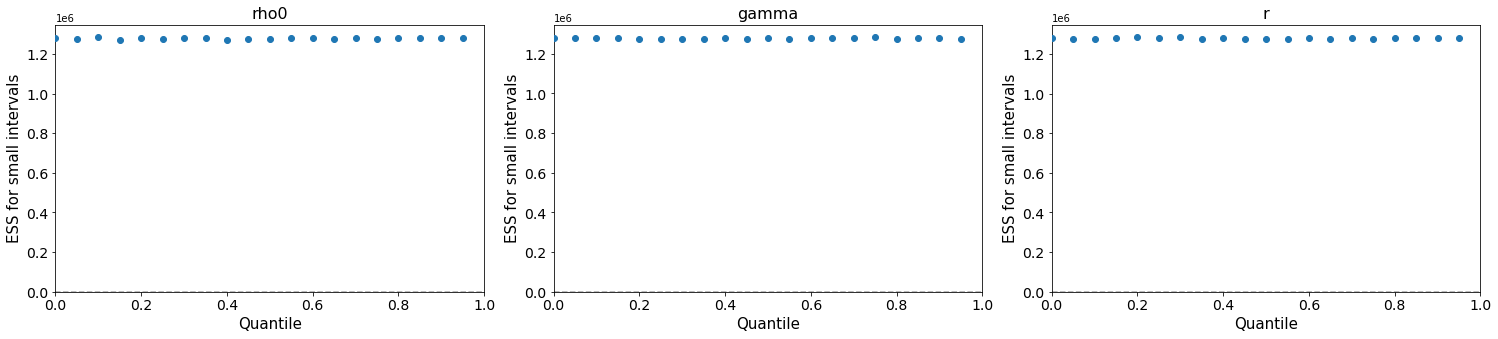

In [5]:
with pm.Model() as m2_both: 
    g = pm.Bound(pm.Kumaraswamy,lower=8e-6)('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-14, upper=-3, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    r = pm.Uniform('r', lower=1e-5, upper=1)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    pm.Poisson("n",
               mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot,
               observed=counts
              )
    t_m2_both = pm.sample_smc(draws=160000, parallel=True, cores=8)
    az.plot_pair(t_m2_both, marginals=True, kind='kde', var_names=['gamma', 'rho0', 'r'], kde_kwargs={'contour':True})
    az.plot_trace(t_m2_both, kind="rank_vlines", var_names=['gamma', 'rho0', 'r'])
    az.plot_ess(t_m2_both, var_names=['rho0', 'gamma', 'r'], kind='local')

In [6]:
b12 = np.exp(np.mean(t_m2_both.report.log_marginal_likelihood) - np.mean(trace.report.log_marginal_likelihood))

In [7]:
(np.sqrt(np.std(t_m2_both.report.log_marginal_likelihood)**2 + 
        np.std(trace.report.log_marginal_likelihood)**2)) * b12

0.022011305751784623

In [8]:
b12

3.519724104255815

# 1/r prior on r

Initializing SMC sampler...
Sampling 8 chains in 8 jobs
Stage:   0 Beta: 0.185
Stage:   1 Beta: 0.847
Stage:   2 Beta: 1.000


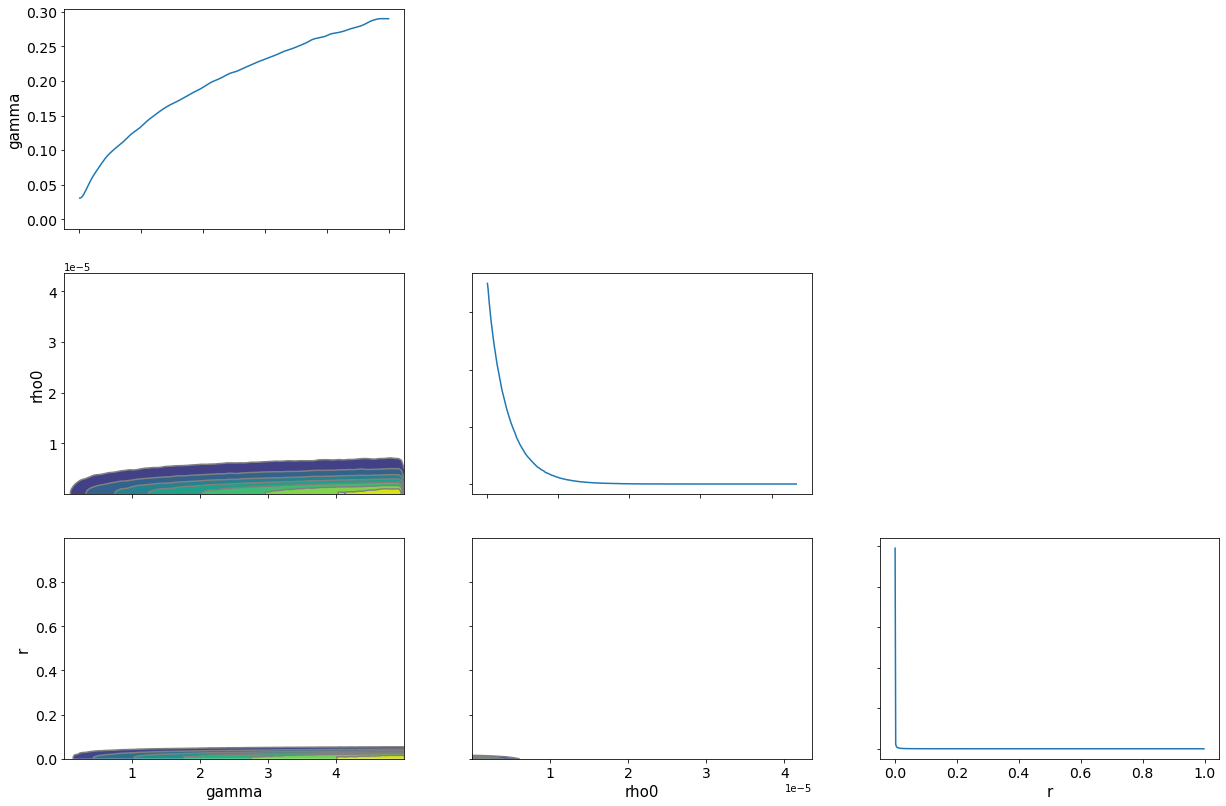

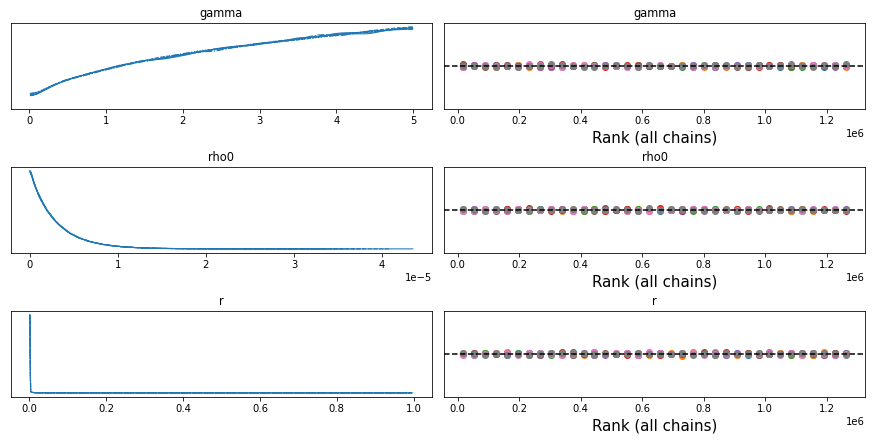

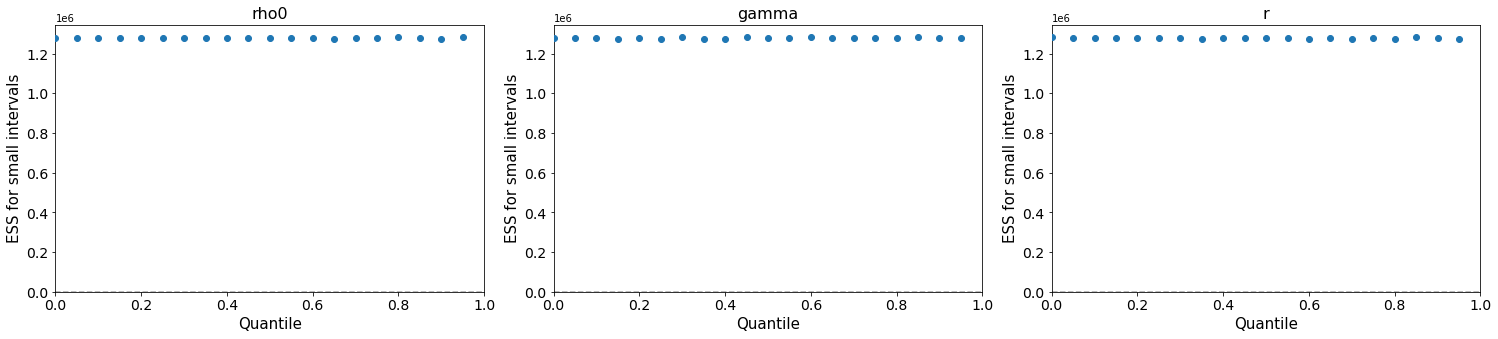

In [9]:
with pm.Model() as m2_both2: 
    g = pm.Bound(pm.Kumaraswamy,lower=1e-15)('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    u = pm.Uniform('u', lower=-14, upper=-3, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    ur = pm.Uniform('ur', lower=-15, upper=0, testval=-3)
    r = pm.Deterministic('r', 10**(ur))
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    pm.Poisson("n",
               mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot,
               observed=counts
              )
    t_m2_both2 = pm.sample_smc(draws=160000, parallel=True, cores=8)
    az.plot_pair(t_m2_both2, marginals=True, kind='kde', var_names=['gamma', 'rho0', 'r'], kde_kwargs={'contour':True})
    az.plot_trace(t_m2_both2, kind="rank_vlines", var_names=['gamma', 'rho0', 'r'])
    az.plot_ess(t_m2_both2, var_names=['rho0', 'gamma', 'r'], kind='local')

In [10]:
b122 = np.exp(np.mean(t_m2_both2.report.log_marginal_likelihood) - np.mean(trace.report.log_marginal_likelihood))

In [11]:
(np.sqrt(np.std(t_m2_both2.report.log_marginal_likelihood)**2 + 
        np.std(trace.report.log_marginal_likelihood)**2)) * b122

0.13694945717343537

In [12]:
b122

28.8343275224715

# 1/r uniform on (1, 2e4)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs
Stage:   0 Beta: 0.188
Stage:   1 Beta: 0.921
Stage:   2 Beta: 1.000
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: No contour levels were found within the data range.
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: No contour levels were found within the data range.
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


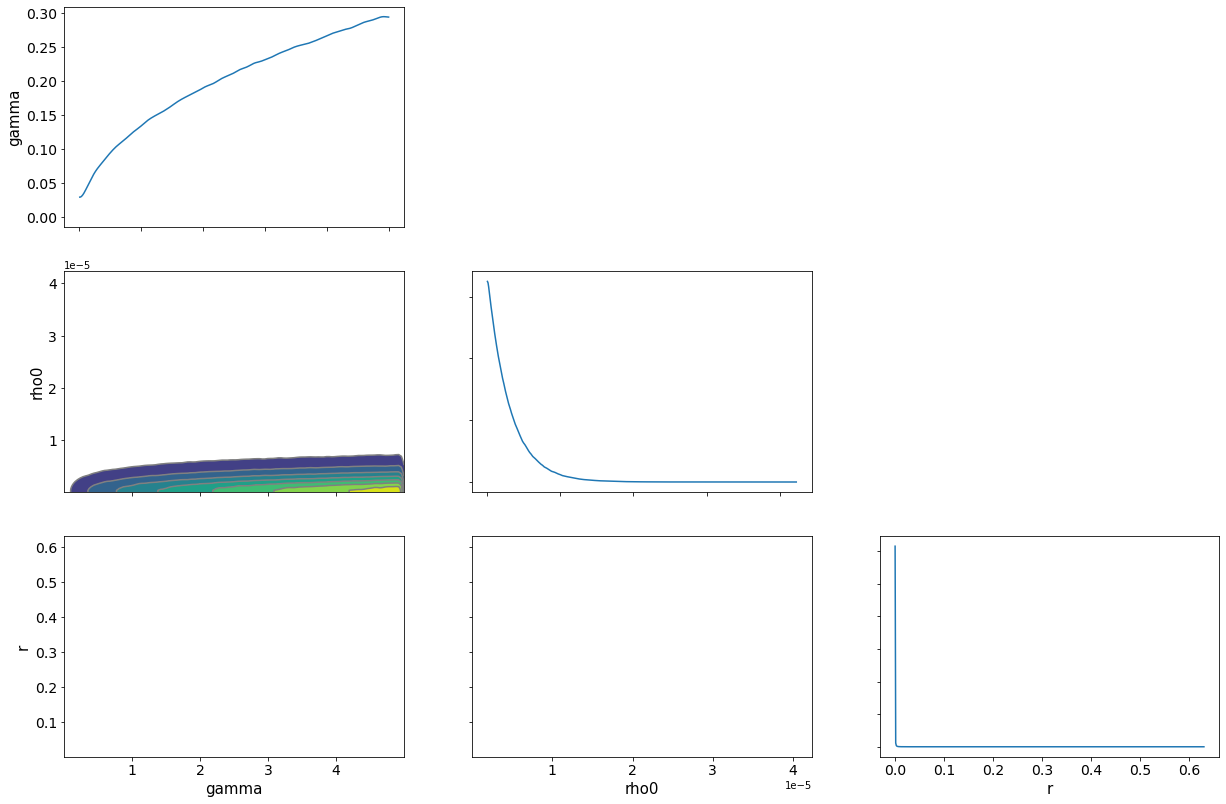

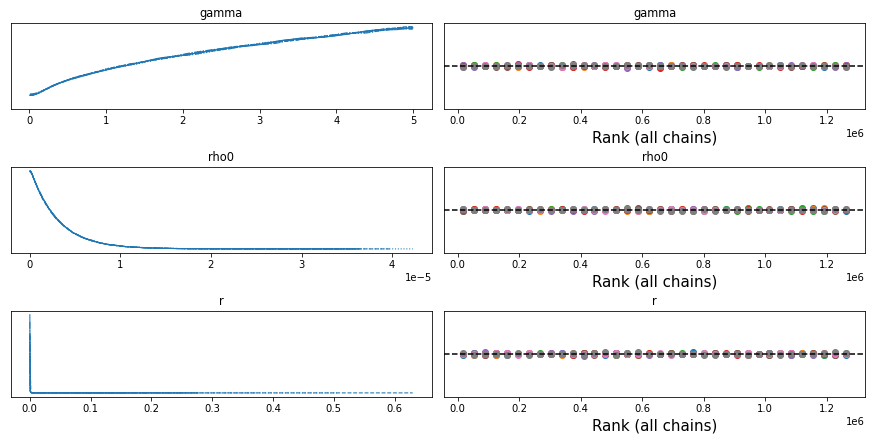

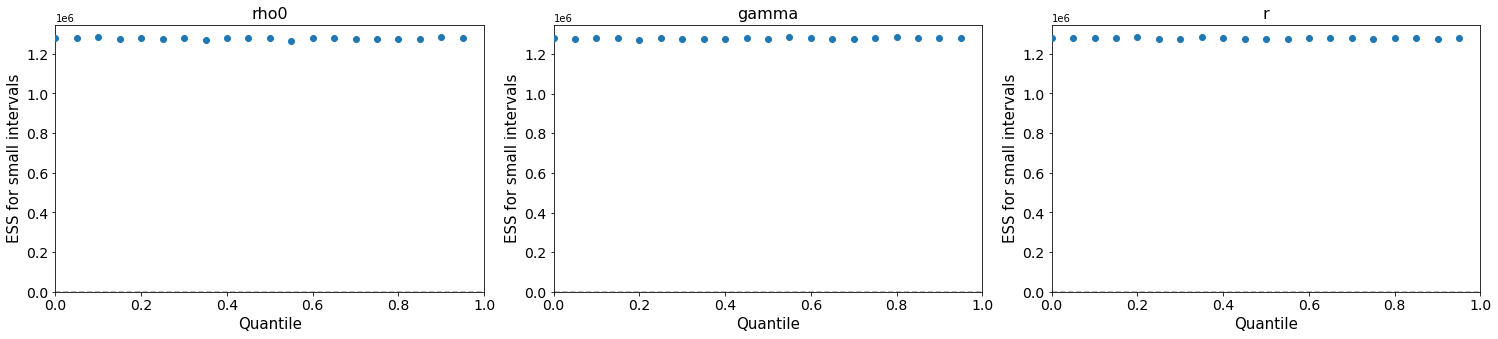

In [13]:
with pm.Model() as m2_both3: 
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    u = pm.Uniform('u', lower=-14, upper=-3, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    one_over_r = pm.Uniform('1/r', lower=1, upper=2e4)
    r = pm.Deterministic('r', 1/one_over_r)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    pm.Poisson("n",
               mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot,
               observed=counts
              )
    t_m2_both3 = pm.sample_smc(draws=160000, parallel=True, cores=8)
    az.plot_pair(t_m2_both3, marginals=True, kind='kde', var_names=['gamma', 'rho0', 'r'], kde_kwargs={'contour':True})
    az.plot_trace(t_m2_both3, kind="rank_vlines", var_names=['gamma', 'rho0', 'r'])
    az.plot_ess(t_m2_both3, var_names=['rho0', 'gamma', 'r'], kind='local')

In [14]:
b123 = np.exp(np.mean(t_m2_both3.report.log_marginal_likelihood) - np.mean(trace.report.log_marginal_likelihood))

In [15]:
b123 * (np.sqrt(np.std(t_m2_both3.report.log_marginal_likelihood)**2 + 
        np.std(trace.report.log_marginal_likelihood)**2))

0.14588859965854548

In [16]:
b123

31.763597677138247

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Sep 13 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

arviz  : 0.11.2
astropy: 4.2.1
pymc3  : 3.11.2
numpy  : 1.21.0

Watermark: 2.2.0

